# Check sync process

In [14]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [ ]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp


#from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir, BehaviorSync
# import u19_pipeline.ephys_sync as ephys
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils
import u19_pipeline.utils.ephys_fix_sync_code as ephys_fix_sync_code
import u19_pipeline.ephys_pipeline as ephys_pipeline


In [16]:
#Behavior data
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
#EphysPipeline = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')

In [81]:
recording_query = "recording_id = 281"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_keys = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


session_fields = ['subject_fullname', 'session_date', 'session_number']
session_keys = (recording.Recording.BehaviorSession & recording_query).fetch(*session_fields, as_dict=True, order_by='recording_id')


recording_keys

[{'recording_id': np.int64(281)}]

In [ ]:
def main_ephys_fix_sync_code(iter_start_idx, iter_times_idx, behavior_time, nidq_sampling_rate):
    iteration_dict = dict()
    iteration_dict['iter_start_idx']  = list()
    iteration_dict['iter_times_idx']  = list()

    for i in range(len(iter_start_idx)):

        #print('fixing trial ',i)
        behavior_time_vector = behavior_time[i].flatten()

        synced_time_vector, shift_vec, median_vec = ephys_utils.get_shift_vector(iter_times_idx[i],behavior_time_vector)
        

        synced_time_vector,_ =\
            ephys_utils.fix_shifted_sync_vector(synced_time_vector, behavior_time_vector, shift_vec)

        #synced_time_vector, trial_stats_dict['borrow_step3'] =\
        #    fix_sync_vector_greater(synced_time_vector, behavior_time_vector)
        synced_time_vector,_ =\
            ephys_utils.complete_last_part_sync_vec(synced_time_vector, behavior_time_vector)

        synced_iteration_vector =\
            ephys_utils.fix_iter_vector(iter_start_idx[i],synced_time_vector, iter_times_idx[i], nidq_sampling_rate)
        

        iteration_dict['iter_start_idx'].append(synced_iteration_vector.copy())
        iteration_dict['iter_times_idx'].append(synced_time_vector.copy())

    print('end fix sync code 1')

    iteration_dict['iter_start_idx'] = np.asarray(iteration_dict['iter_start_idx'].copy(), dtype=object)
    iteration_dict['iter_times_idx'] = np.asarray(iteration_dict['iter_times_idx'].copy(), dtype=object)

    print('end fix sync code')

    # Check # of trials and iterations match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    print('after assert_iteration_samples_count fix sync code')

    if trial_count_diff != 0:
        print('trial_count_diff', trial_count_diff)
    if len(trials_diff_iteration_big) > 0:
        print('trials_diff_iteration_big', trials_diff_iteration_big)
    if len(trials_diff_iteration_small) > 0:
        print('trials_diff_iteration_small', trials_diff_iteration_small)



    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])

    print('after evaluate_sync_process fix sync code')

    for i in range(len(iteration_dict['iter_start_idx'])):
        synced_time_vector = iteration_dict['iter_times_idx'][i]
        behavior_time_vector = behavior_time[i].flatten()

        status = ephys_fix_sync_code.sync_evaluation_process2(synced_time_vector, behavior_time_vector)
        if status == -1:
            break

    print('after sync_evaluation_process2', status)

    if status == 1:
        iteration_dict['trial_start_idx'] = ephys_utils.get_index_trial_vector_from_iteration(iteration_dict['iter_start_idx'])

    return status, iteration_dict

In [ ]:
def main_regular_sync(key, **kwargs):

    ephys_session_fullpath = ephys_pipeline.get_full_session_directory(key)

    # Get behavior key
    behavior_key = (recording.Recording.BehaviorSession & key).fetch1()
    behavior_key.pop('recording_id')

    if 'testuser' in behavior_key['subject_fullname']:
        return

    # If a specific block is requested, add that to our behavior_key. It should be an int referring to virmen block number.
    # This is useful for sessions in which the nidaq stream was interrupted due to restarting virmen
    if 'block' in kwargs:
        print('block: ', kwargs['block'])
        behavior_key['block'] = kwargs['block']

    print(behavior_key)

    # And get the datajoint record
    behavior = dj.create_virtual_module('behavior', 'u19_behavior')
    thissession = behavior.TowersBlock().Trial() & behavior_key
    behavior_time, iterstart = thissession.fetch('trial_time', 'vi_start')

    print('len iterstart', len(iterstart))

    if len(iterstart) == 0:
        raise ValueError('No behavior found')

    print('after reading behavior data')

    # 1: load meta data, and the content of the NIDAQ file. Its content is digital.
    nidq_meta, nidq_sampling_rate = ephys_utils.read_nidq_meta_samp_rate(ephys_session_fullpath)

    trial_pulse_signal, iteration_pulse_signal = ephys_utils.load_trial_iteration_signals(ephys_session_fullpath, nidq_meta)

    print('after reading spikeglx data')

    # Synchronize between pulses and get iteration # vector for each sample
    recent_recording = behavior_key['session_date'] > datetime.date(2021,6,1) # Everything past June 1 2021
    if recent_recording:
        # New synchronization method: digital_array[1,2] contain pulses for trial and frame number.
        mode=None
        iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal, nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode)
    else:
        # Old synchronization: digital_array[0:7] contain a digital word that counts the virmen frames.
        raise ValueError('Old sessions < 2022 not suported anymore')
        #iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_word(digital_array, behavior_time, iterstart)

    # Check # of trials (from database record of behavior in `behavior_time`) and iterations (extracted from NIDAQ in `iter_start_idx`) match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    print('metrics to evaluate...')
    print(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small, behavior_time.shape[0])

    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small, behavior_time.shape[0])

    if status == 1:
        iteration_dict['trial_start_idx'] = ephys_utils.get_index_trial_vector_from_iteration(iteration_dict['iter_start_idx'])

    #Failed sync by a lot, error
    status_regular = 1
    status_fix = 0
    if status < 1:
        status_regular = 0
        print('Regular ephys sync failed')
        status_fix, iteration_dict = main_ephys_fix_sync_code(iteration_dict['iter_start_idx'], iteration_dict['iter_times_idx'], behavior_time, nidq_sampling_rate)

    dictionary_sync_data = dict()

    print('after all main ehpys fix sync code', status_regular, status_fix)

    if status_regular or status_fix:
        dictionary_sync_data['trial_idx_vector'] = iteration_dict['trial_start_idx']
        dictionary_sync_data['iteration_idx_vector'] = iteration_dict['iter_start_idx']
    else:
        dictionary_sync_data['trial_idx_vector'] = []
        dictionary_sync_data['iteration_idx_vector'] = []

    iteration_dict['trial_start_idx_virmen'], iteration_dict['iter_start_idx_virmen'] =\
        ephys_utils.get_iteration_intertrial_from_virmen_time(trial_pulse_signal, nidq_sampling_rate, behavior_time.shape[0], behavior_time)
    
    dictionary_sync_data['trial_idx_vector_from_virmen'] = iteration_dict['trial_start_idx_virmen']
    dictionary_sync_data['iteration_idx_vector_from_virmen'] = iteration_dict['iter_start_idx_virmen']

# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

In [ ]:
trial_sync_stats = []

max_diff_virmen_vs_trad = []
min_diff_virmen_vs_trad = []
for idx_session in range(len(recording_keys)):
    recording_key = recording_keys[idx_session]
    session_key = session_keys[idx_session]

    session_dir = find_full_path(get_ephys_root_data_dir(),
                                get_session_directory(recording_key))
    print(session_dir)
    #session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
    #Check if session is Nidq or OneBox
    nidq_session = list(session_dir.glob('*nidq.bin*'))
    obx_session = list(session_dir.glob('*obx.bin*'))

    if len(nidq_session) == 0 and len(obx_session) == 0:
        print('No session found')
    elif len(nidq_session) > 0:
        ephys_session_fullpath = nidq_session[0]
    else:
        ephys_session_fullpath = obx_session[0]

    #Nidaq file
    nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
    nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


    # 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
    new_trial_channel = 1
    new_iteration_channel = 2
    # If PXIe card (nidq) card use for recording deduce digital channels
    if nidq_meta['typeThis'] == 'nidq':
        digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
    # If onebox card (obx) card use for recording digital channels are 0-2
    else:
        digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
        # If no sync pulse found trial and iteration signals are 0 & 1 respectively
        channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
        channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

        if channel0_pulses > channel1_pulses:
            new_trial_channel = 1
            new_iteration_channel = 0
        else:
            new_trial_channel = 0
            new_iteration_channel = 1

    
    thissession = behavior.TowersBlock().Trial() & session_key
    behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')

    mode = None   #Default for sessions before 12/01/2021
    #mode = 'pulses'    #Default for sessions after 12/01/2021
    iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)

    _, iteration_dict['iter_intertrial_from_virmen'] = ephys_utils.get_iteration_intertrial_from_virmen_time(digital_array[new_trial_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time)

    iteration_dict['framenumber_vector_samples'], iteration_dict['trialnumber_vector_samples'] =\
        ephys_utils.get_full_vector_samples(iteration_dict['iter_start_idx'], nidq_sampling_rate, digital_array.shape[1])
    
    iteration_dict['framenumber_vector_samples_from_virmen'], iteration_dict['trialnumber_vector_samples_from_virmen'] =\
        ephys_utils.get_full_vector_samples(iteration_dict['iter_intertrial_from_virmen'], nidq_sampling_rate, digital_array.shape[1])

    diff_virmen_vs_trad = iteration_dict['framenumber_vector_samples_from_virmen'] - iteration_dict['framenumber_vector_samples']

    max_diff_virmen_vs_trad.append(np.nanmax(diff_virmen_vs_trad))
    min_diff_virmen_vs_trad.append(np.nanmin(diff_virmen_vs_trad))

    extreme_cases = list()
    ghost_iter = list()
    ghost_iter2 = list()
    
    for i in range(len(iteration_dict['iter_start_idx'])):

        trial_stats_dict= {}
        trial_stats_dict['num_trial'] = i+1

        #print('fixing trial ',i)
        behavior_time_vector = behavior_time[i].flatten()
        synced_time_vector, shift_vec, median_vec = ephys_utils.get_shift_vector(iteration_dict['iter_times_idx'][i],behavior_time_vector)
        trial_stats_dict['max_shift'] = np.max(shift_vec)
        trial_stats_dict['min_shift'] = np.min(shift_vec)
        trial_stats_dict['median_diff'] = median_vec[1]
        trial_stats_dict['min_diff'] = median_vec[0]
        trial_stats_dict['max_diff'] = median_vec[2]
        
        synced_time_vector,trial_stats_dict['borrow_step2'] =\
            ephys_utils.fix_shifted_sync_vector(synced_time_vector, behavior_time_vector, shift_vec)

        idx_ghost_iter = np.where(np.diff(synced_time_vector)<0)
        idx_ghost_iter = idx_ghost_iter[0]
        if idx_ghost_iter.shape[0] > 0:
            ghost_iter.append(i)

        #synced_time_vector, trial_stats_dict['borrow_step3'] =\
        #    fix_sync_vector_greater(synced_time_vector, behavior_time_vector)
        synced_time_vector, trial_stats_dict['borrow_step4'] =\
            complete_last_part_sync_vec(synced_time_vector, behavior_time_vector)

        idx_ghost_iter = np.where(np.diff(synced_time_vector)<=0)
        idx_ghost_iter = idx_ghost_iter[0]
        if idx_ghost_iter.shape[0] > 0:
            ghost_iter2.append(i)

        synced_iteration_vector =\
            fix_iter_vector(iteration_dict['iter_start_idx'][i],synced_time_vector, iteration_dict['iter_times_idx'][i], nidq_sampling_rate)
        

        if iteration_dict['iter_times_idx'][i].shape[0] < behavior_time_vector.shape[0] - 20:
            extreme_cases.append(i)

        iteration_dict['iter_start_idx'][i] = synced_iteration_vector.copy()
        iteration_dict['iter_times_idx'][i] = synced_time_vector.copy()

        trial_stats_dict['num_iterations'] = iteration_dict['iter_times_idx'][i].shape[0] 

        trial_stats_dict = trial_stats_dict | session_key
        trial_sync_stats.append(trial_stats_dict)


    
    # Check # of trials and iterations match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    if trial_count_diff != 0:
        print('trial_count_diff', trial_count_diff)
    if len(trials_diff_iteration_big) > 0:
        print('trials_diff_iteration_big', trials_diff_iteration_big)
    if len(trials_diff_iteration_small) > 0:
        print('trials_diff_iteration_small', trials_diff_iteration_small)


    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])

    for i in range(len(iteration_dict['iter_start_idx'])):
        synced_time_vector = iteration_dict['iter_times_idx'][i]
        behavior_time_vector = behavior_time[i].flatten()

        if i in ghost_iter:
            print('Ghost iteration')
            print(session_key)
            print(recording_key)
            print(i)
        if i in ghost_iter2:
            print('Ghost iteration 2')
            print(session_key)
            print(recording_key)
            print(i)
        if i in extreme_cases:
            print('Too extreme to evaluate')
            print(session_key)
            print(recording_key)
            print(i)

        status = sync_evaluation_process2(synced_time_vector, behavior_time_vector)
        if status == 0:
            print(session_key)
            print(recording_key)
            print(i)
            if i!=0:
                break

    final_key = dict(recording_key, nidq_sampling_rate = nidq_sampling_rate,
                         iteration_index_nidq = iteration_dict['framenumber_vector_samples'],
                         trial_index_nidq = iteration_dict['trialnumber_vector_samples'])


    print(final_key)

    BehaviorSync.insert1(final_key,allow_direct_insert=True, skip_duplicates=True)

    BehaviorSync_obj = BehaviorSync()
    BehaviorSync_obj.insert_imec_sampling_rate(recording_key, session_dir)
    
    if status == 0:
        break
        


\\cup.pni.princeton.edu\braininit\Data\Raw\electrophysiology\jk8386\jk8386_jknpx5\20240402_g0\jknpx5_04022024_g0
['0', '7']
nChan: 1, nFileSamp: 18513614


mode deduction:  counter_bit0
Synced perfectly xxxxxxxxxxxxxx
Ghost iteration 2
{'subject_fullname': 'jk8386_jknpx5', 'session_date': datetime.date(2024, 4, 2), 'session_number': np.int64(0)}
{'recording_id': np.int64(281)}
37
Ghost iteration 2
{'subject_fullname': 'jk8386_jknpx5', 'session_date': datetime.date(2024, 4, 2), 'session_number': np.int64(0)}
{'recording_id': np.int64(281)}
40
Ghost iteration 2
{'subject_fullname': 'jk8386_jknpx5', 'session_date': datetime.date(2024, 4, 2), 'session_number': np.int64(0)}
{'recording_id': np.int64(281)}
52
Ghost iteration 2
{'subject_fullname': 'jk8386_jknpx5', 'session_date': datetime.date(2024, 4, 2), 'session_number': np.int64(0)}
{'recording_id': np.int64(281)}
111
{'recording_id': np.int64(281), 'nidq_sampling_rate': 5000.062709, 'iteration_index_nidq': array([nan, nan, nan, ..., nan, nan, nan], shape=(18513614,)), 'trial_index_nidq': array([nan, nan, nan, ..., nan, nan, nan], shape=(18513614,))}


(-0.01, 0.02)

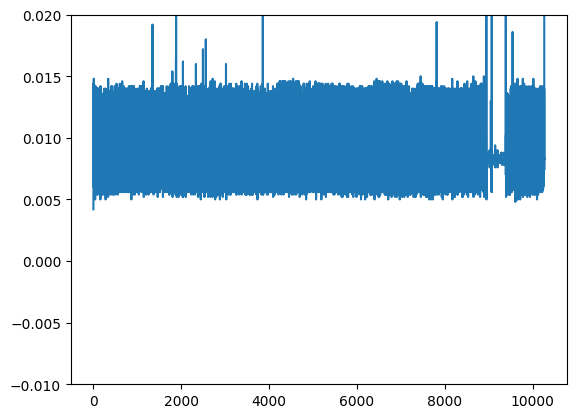

In [83]:
plt.plot(np.diff(synced_time_vector))
plt.ylim([-0.01, 0.02])

In [80]:
idx_ghost_iter = np.where(np.diff(synced_time_vector)<=0)
idx_ghost_iter

(array([], dtype=int64),)

In [62]:
print(iteration_dict['framenumber_vector_samples'][8558940:8558950])

[713. 713. 713. 713. 713. 713. 714. 714. 714. 714.]


In [68]:
sync_data2 = (BehaviorSync & "recording_id=339").fetch(as_dict=True)

In [69]:
print(sync_data2[0]['iteration_index_nidq'][8558940:8558950])

[713. 713. 713. 713. 713. 713. 714. 714. 714. 714.]


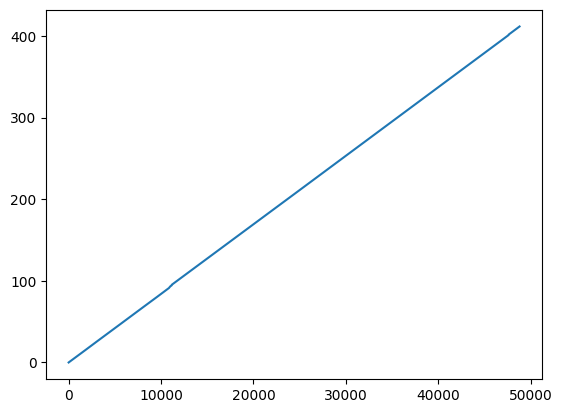

In [ ]:
plt.plot(behavior_time_vector)

In [35]:
print(max_diff_virmen_vs_trad)
print(min_diff_virmen_vs_trad)

[np.float64(9.0)]
[np.float64(-3.0)]


In [20]:
9*1000/30000

0.3

In [50]:
import pandas as pd
trial_sync_stats_df = pd.DataFrame(trial_sync_stats)

In [51]:
trial_sync_stats_df

,num_trial,max_shift,min_shift,median_diff,min_diff,max_diff,borrow_step2,borrow_step3,borrow_step4,num_iterations,subject_fullname,session_date,session_number
0,1,0,0,-0.033308,-0.040308,-0.026308,[],"[[467, 468], [530, 531], [1130, 1131]]",[],1132,jyanar_ya054,2025-10-11,0
1,2,0,0,-0.012339,-0.019339,-0.005339,[],"[[360, 362], [421, 422], [543, 544]]",[],545,jyanar_ya054,2025-10-11,0
2,3,0,0,-0.014077,-0.021077,-0.007077,[],"[[353, 355], [414, 415], [536, 537]]",[],538,jyanar_ya054,2025-10-11,0
3,4,0,0,-0.014415,-0.021415,-0.007415,[],"[[338, 339], [398, 399], [520, 521]]",[],522,jyanar_ya054,2025-10-11,0
4,5,0,0,-0.008597,-0.015597,-0.001597,[],"[[385, 386], [446, 447], [568, 569]]",[],570,jyanar_ya054,2025-10-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,278,0,0,-0.027175,-0.034175,-0.020175,[],"[[377, 378], [438, 439], [560, 561]]",[],562,jyanar_ya054,2025-10-11,0
278,279,0,0,-0.027536,-0.034536,-0.020536,[],"[[389, 390], [450, 451], [572, 573]]",[],574,jyanar_ya054,2025-10-11,0
279,280,0,0,-0.027785,-0.034785,-0.020785,[],"[[283, 284], [344, 345], [466, 467]]",[],468,jyanar_ya054,2025-10-11,0
280,281,0,0,-0.030779,-0.037779,-0.023779,[],"[[833, 834], [894, 895], [1016, 1017]]",[],1018,jyanar_ya054,2025-10-11,0


Text(0.5, 1.0, 'Median diff NIDAQ - ViRMEn')

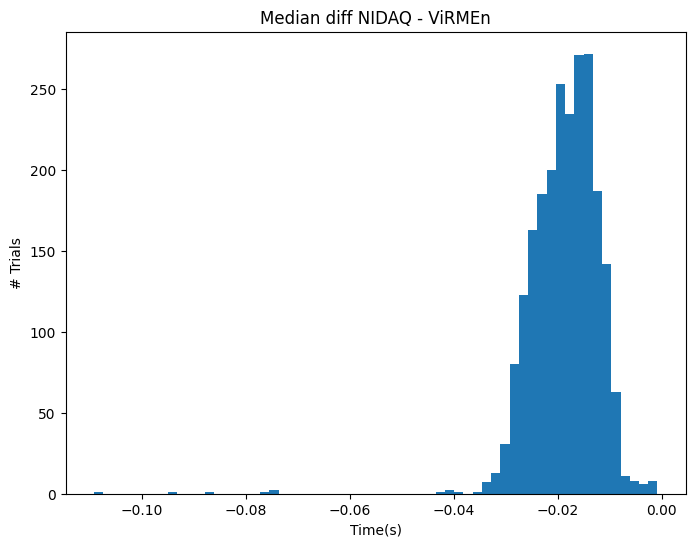

In [ ]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['median_diff'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts,bins=61)


plt.xlabel('Time(s)')
plt.ylabel('# Trials')
plt.title('Median diff NIDAQ - ViRMEn')

In [ ]:

trial_sync_stats_df['min_shift_abs'] = trial_sync_stats_df['min_shift'].abs()
trial_sync_stats_df['shift'] = trial_sync_stats_df[['max_shift', 'min_shift_abs']].max(axis=1)

trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift'] = trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift']*-1


Text(0.5, 1.0, '"Max" shift in trial to preserve median: 2184 trials without shift')

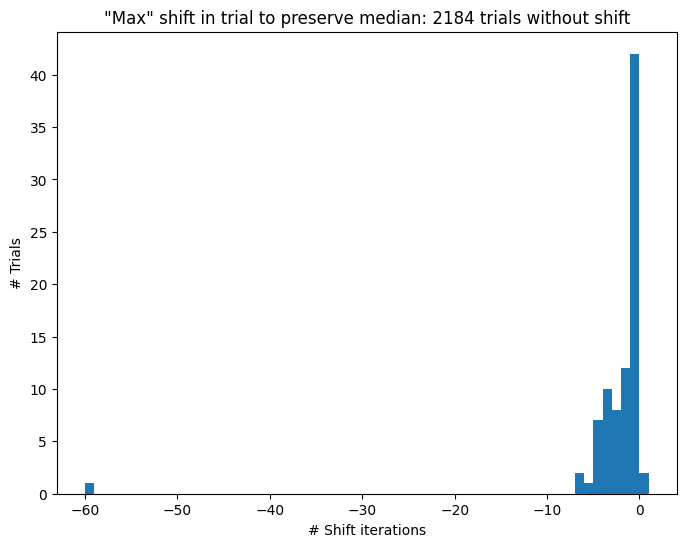

In [ ]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['shift'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts,bins=61)


plt.xlabel('# Shift iterations')
plt.ylabel('# Trials')
plt.title('"Max" shift in trial to preserve median: '+ str(num_0_shifts)+ ' trials without shift')

In [ ]:
def count_borrowed_iter(borrow_list):
    num_borrow = 0
    for i in range(len(borrow_list)):
        num_borrow = num_borrow+ borrow_list[i][1] - borrow_list[i][0] + 1

    return num_borrow


In [ ]:
trial_sync_stats_df['num_borrow_step2'] = trial_sync_stats_df['borrow_step2'].apply(count_borrowed_iter)
trial_sync_stats_df['num_borrow_step3'] = trial_sync_stats_df['borrow_step3'].apply(count_borrowed_iter)
trial_sync_stats_df['num_borrow_step4'] = trial_sync_stats_df['borrow_step4'].apply(count_borrowed_iter)


trial_sync_stats_df['total_borrow'] = trial_sync_stats_df['num_borrow_step2'] + trial_sync_stats_df['num_borrow_step3'] + trial_sync_stats_df['num_borrow_step4']  

trial_sync_stats_df['percentage_borrow'] = trial_sync_stats_df['total_borrow']*100 / trial_sync_stats_df['num_iterations']


Text(0.5, 1.0, 'Trial NIDAQ iterations borrowed from ViRMEn')

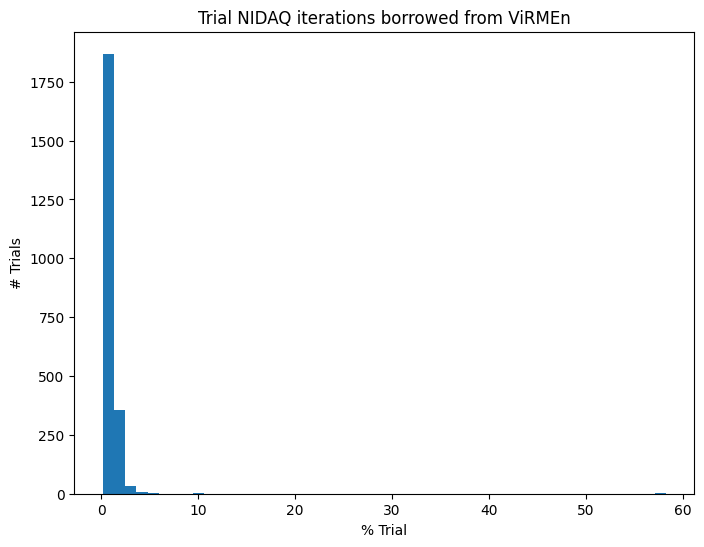

In [ ]:
plt.figure(figsize=(8, 6))



plt.hist(trial_sync_stats_df['percentage_borrow'],bins=50)


plt.xlabel('% Trial')
plt.ylabel('# Trials')
plt.title('Trial NIDAQ iterations borrowed from ViRMEn')

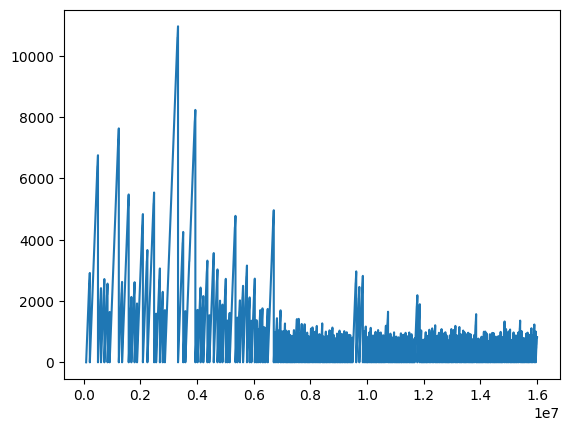

In [ ]:
plt.plot(iteration_dict['framenumber_vector_samples'])

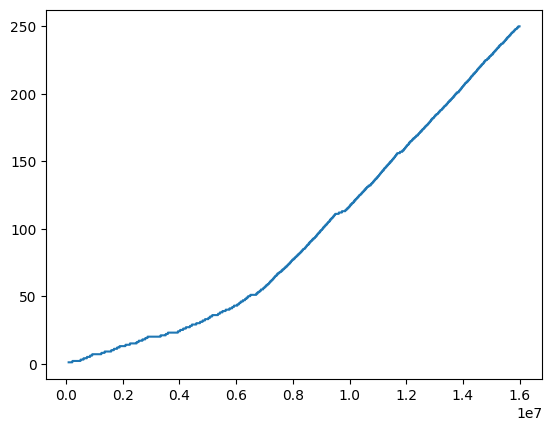

In [ ]:
plt.plot(iteration_dict['trialnumber_vector_samples'])